## <span style="color:green"> Laboratorio di simulazione numerica </span>
### Martina Colombo, 977556
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>
## <span style="color:blue">  Esercitazione 12</span>

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML

import tensorflow as tf
from tensorflow import keras
import os
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax


In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

#### Introduzione

Lo scopo di questa esercitazione è di utilizzare le reti neurali per risolvere un problema di classificazione. La rete deve essere in grado di distringuere e riconoscere dieci caratteri numerici compresi tra $0$ e $9$. A tale scopo utilizziamo il database MNIST che comprende $70000$ immagini di cifre scritte a mano  ($60000$ immagini di training e $10000$ immagini di test) ognuna delle quali è racchiusa in un'immagine quadrata formata da $28 \times 28$ pixel, ogni pixel può assumere $256$ gradazioni di grigio da bianco a nero, ogni gradazione ha un valore numerico assegnato. 

Le fasi per risolvere il problema sono:
1. Caricare i dati di training e di test dal database MNIST;
2. Definire la rete neurale e la sua architettura;
3. Scegliere l'ottimizzatore e la funzione di costo;
4. Allenare il modello;
5. Valutare il modello sui dati di test e analizzare i grafici della funzione di loss e dell'accuratezza in funzione del numero di epoche.

In questa esercitazione utilizzeremo due tipi di reti neurali: una rete neurale profonda (DNN) e una rete neurale profonda di tipo convoluzionale (CNN). 

### Esercizio 12.1

Dopo aver caricato i dati dal database MNIST costruiamo per una prima analisi una rete neurale profonda formata da:

- un layer di input formato da $400$ neuroni che prendono in ingresso i dati di train $(X_{train}, Y_{train})$, con funzione di attivazione 'relu';
- un layer con $100$ neuroni con funzione di attivazione 'relu';
- un layer di dropout utile per evitare l'overfitting dei dati e irrobustire la rete;
- un layer di output formato da $10$ neuroni con funzione di attivazione 'softmax' utile per i problemi di classificazione.

Le $X_{train}$ rappresentano una matrice $28\times 28$, ad ogni riga della matrice è associato il rispettivo valore $Y_{train}$ ovvero una label da $0$ a $9$, poiché la nostra rete deve risolvere un problema di classificazione e il layer di output è formato da $10$ neuroni è conveniente modificare la forma delle $Y_{train}$ facendole diventare dei vettori di $10$ componenti ciascuno tramite la funzione `to_categorical`, i vettori saranno a questo punto formati da tutti $0$ a meno di un $1$ nella posizione corrispondente alla label che deve rappresentare. Questa scelta nella formattazione dei dati di output porta con sè la logica scelta di utilizzare come funzione di loss la 'categorical_crossentropy' utilizzata nei problemi di classificazione.

In questo primo esercizio analizziamo come cambia il potere predittivo della rete al variare del tipo di ottimizzatore utilizzato.  Lo scopo degli ottimizzatori è quello di costruire un processo iterativo che minimizzi la funzione di loss. Gli ottimizzatori che prendiamo in cosiderazione si basano tutti sul metodo della discesa del gradiente, le loro differenze risiedono nella scelta dei rate di apprendimento e da come questi vengono aggiornati.

I tipi di ottimizzatore che consideriamo sono:
1. **SGD** : metodo che utilizza la discesa del gradiente in maniera stocastica, il gradiente non è calcolato per tutti i dati del set di training soltanto per un sottoinsieme scelto in modo casuale, durante il processo di minimizzazzione i tassi di apprendimento rimangono costanti;
2. **Adagrad** : ottimizzatore per cui i rate di apprendimento non rimangono costanti ma vengono via via adattati in modo automatico, più un parametro viene aggiornato, minore è la capacità di apprendimento;
3. **Adadelta** : rappresenta un'estensione di Adagrad, adatta i tassi di apprendimento in base a una finestra mobile di aggiornamenti del gradiente invece di accumulare tutti i gradienti calcolati in precedenza.
4. **Adam** : ottimizzatore che si basa sulla stima del momento primo e secondo del gradiente;
5. **Adamax** : è una variante di Adam che usa la norma del massimo del gradiente nella stima del momento secondo.


Alleniamo i vari modelli scegliendo un numero di epoche pari a $15$. Riportiamo di seguito i grafici dell'accuratezza e della funzione di loss per i dati di train e di test al variare del numero di epoche.

In [39]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# training parameters
batch_size = 32
epochs = 15

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)
#print()
#print(X_train.shape[0], 'train samples')
#print(X_test.shape[0], 'test samples')

In [40]:
# reshape data, it could depend on Keras backend
#mettiamo le immagini su un vettore di componenti 28x28
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
#print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
#plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
#plt.show()

#modifichiamo le label dei dati, infatti vogliamo che come output ci siano 10 neuroni aventi
#tanti zeri e un uno soltanto corriposndente alla label cercata
#print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
#print('... and with label', Y_train[20], 'after to_categorical')
#print()
#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)

In [41]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

#print('Model architecture created successfully!')

In [76]:
def compile_model1():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    return model

#print('Model compiled successfully and ready to be trained.')

In [42]:
def compile_model2():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adagrad(),
                  metrics=['accuracy'])
    return model

In [78]:
def compile_model3():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model

In [79]:
def compile_model4():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [80]:
def compile_model5():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adamax(),
                  metrics=['accuracy'])
    return model

In [81]:
# create the deep neural net for SGD
model_DNN1 = compile_model1()

# train DNN and store training info in history
history1 = model_DNN1.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [43]:
# create the deep neural net for SGD
model_DNN2 = compile_model2()

# train DNN and store training info in history
history2 = model_DNN2.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [83]:
# create the deep neural net for SGD
model_DNN3 = compile_model3()

# train DNN and store training info in history
history3 = model_DNN3.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [84]:
# create the deep neural net for SGD
model_DNN4 = compile_model4()

# train DNN and store training info in history
history4 = model_DNN4.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [85]:
# create the deep neural net for SGD
model_DNN5 = compile_model5()

# train DNN and store training info in history
history5 = model_DNN5.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

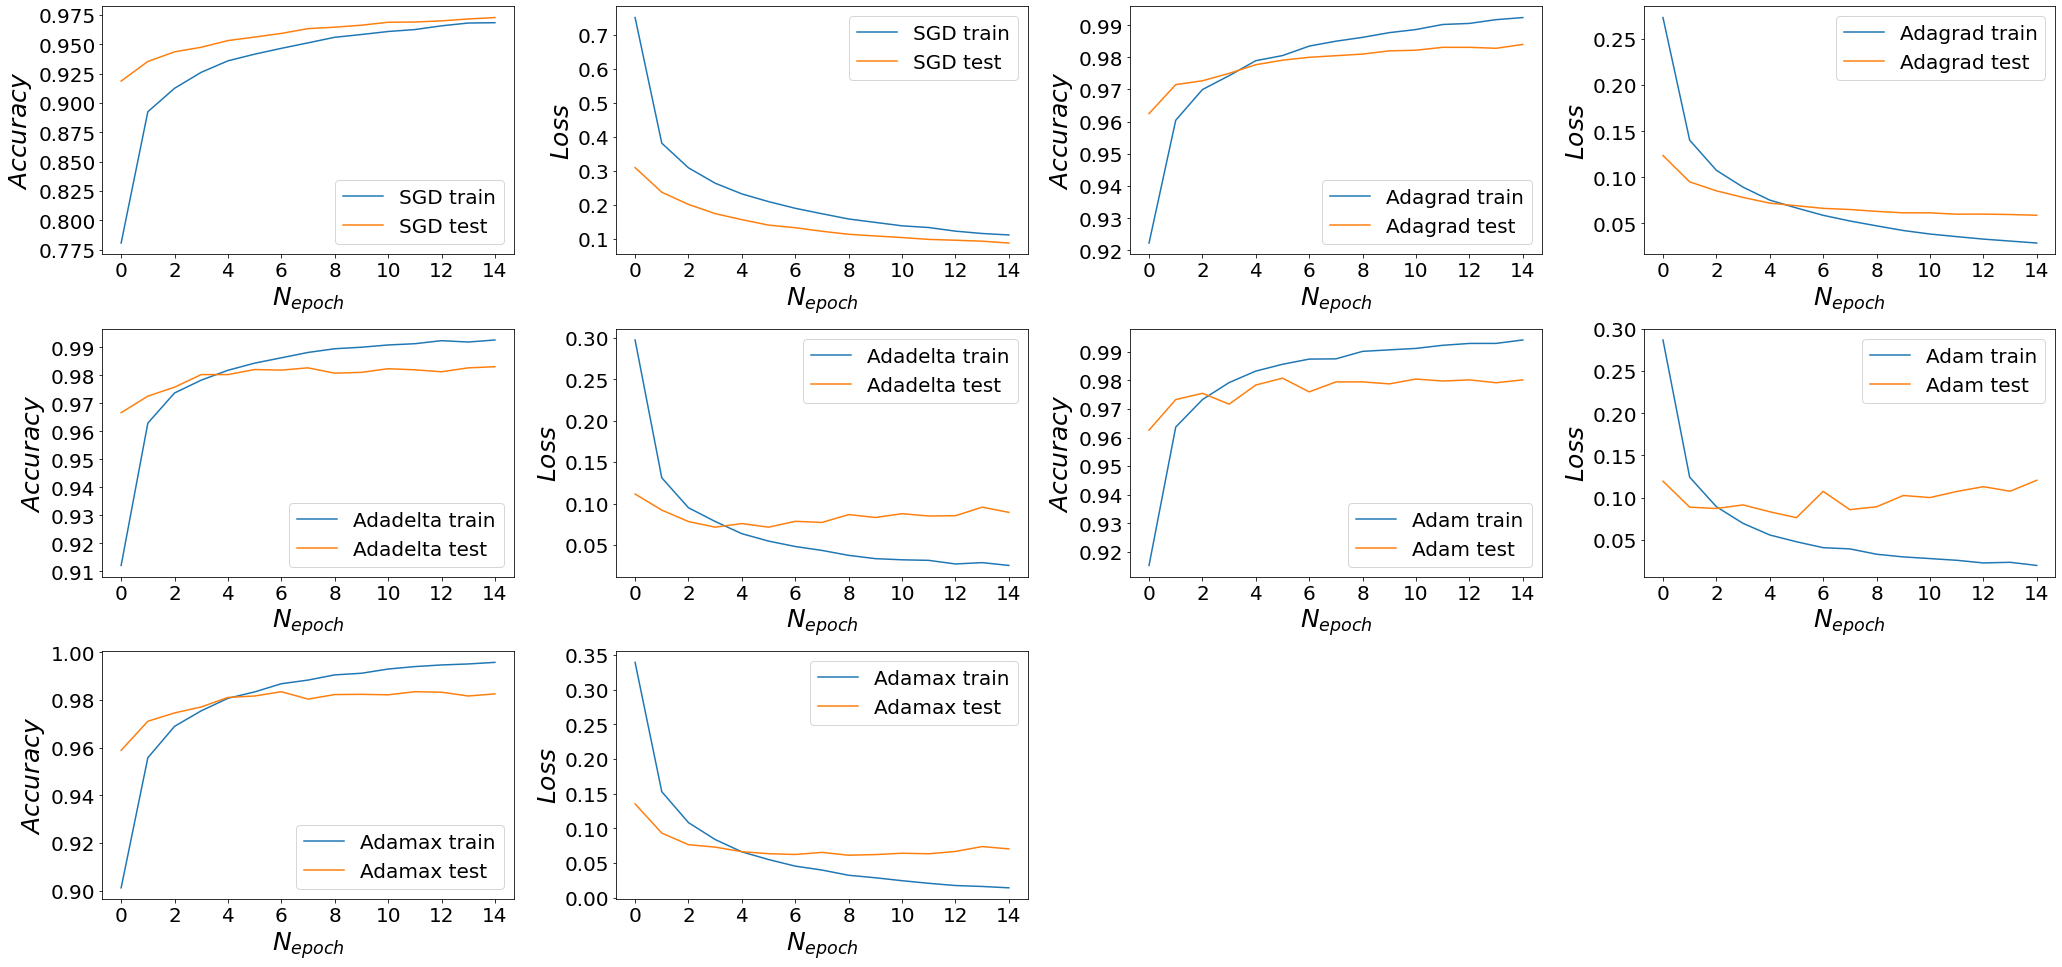

In [95]:
plt.figure(figsize=(35,16))

plt.subplot(3,4,1)

plt.plot(history1.history['accuracy'], label='SGD train')
plt.plot(history1.history['val_accuracy'], label='SGD test')
plt.ylabel('$Accuracy$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,2)

plt.plot(history1.history['loss'], label='SGD train')
plt.plot(history1.history['val_loss'], label='SGD test')
plt.ylabel('$Loss$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,3)

plt.plot(history2.history['accuracy'], label='Adagrad train')
plt.plot(history2.history['val_accuracy'], label='Adagrad test')
plt.ylabel('$Accuracy$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,4)

plt.plot(history2.history['loss'], label='Adagrad train')
plt.plot(history2.history['val_loss'], label='Adagrad test')
plt.ylabel('$Loss$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,5)

plt.plot(history3.history['accuracy'], label='Adadelta train')
plt.plot(history3.history['val_accuracy'], label='Adadelta test')
plt.ylabel('$Accuracy$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)


plt.subplot(3,4,6)


plt.plot(history3.history['loss'], label='Adadelta train')
plt.plot(history3.history['val_loss'], label='Adadelta test')
plt.ylabel('$Loss$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)


plt.subplot(3,4,7)

plt.plot(history4.history['accuracy'], label='Adam train')
plt.plot(history4.history['val_accuracy'], label='Adam test')
plt.ylabel('$Accuracy$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)


plt.subplot(3,4,8)

plt.plot(history4.history['loss'], label='Adam train')
plt.plot(history4.history['val_loss'], label='Adam test')
plt.ylabel('$Loss$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,9)

plt.plot(history5.history['accuracy'], label='Adamax train')
plt.plot(history5.history['val_accuracy'], label='Adamax test')
plt.ylabel('$Accuracy$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplot(3,4,10)

plt.plot(history5.history['loss'], label='Adamax train')
plt.plot(history5.history['val_loss'], label='Adamax test')
plt.ylabel('$Loss$', fontsize=25 )
plt.xlabel('$N_{epoch}$', fontsize=25)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', fontsize=20)

plt.subplots_adjust(top=0.9, wspace=0.25, hspace=0.3)

plt.show()

Osservando i grafici si nota che per gli ottimizzatori Adadelta, Adam e Adamax le funzioni di loss dopo una iniziale decrescita tendono a crescere con l'aumentare del numero di epoche, questa tendenza può indicare la presenza di overfitting dei dati. Nei gli ottimizzatori SGD e Adagrad non riscontriamo questo andamento, consideriamo dunque soltanto questi ultimi per predirre il modello.

Riportiamo di seguito i valori della loss e dell'accuratezza sui dati di test di entrambi i modelli considerati.

In [119]:
# evaluate models
score1 = model_DNN1.evaluate(X_test, Y_test, verbose=0)
score2 = model_DNN2.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss SGD:', score1[0])
print('Test accuracy SGD:', score1[1])
print()
print('Test loss Adagrad:', score2[0])
print('Test accuracy Adagrad:', score2[1])
print()


Test loss SGD: 0.08715872862795368
Test accuracy SGD: 0.9728000164031982

Test loss Adagrad: 0.05875371182007075
Test accuracy Adagrad: 0.984000027179718



Vediamo che il valore della loss ottenuto tramite l'ottimizzatore Adagrad è minore della loss ottenuta tramite SGD, l'accuratezza del modello con ottimizzatore Adagrad risulta maggiore rispetto a quella ottenuta con SGD, ci possiamo aspettiamo dunque che le performance del modello con ottimizzatore Adagrad siano migliori rispetto a quelle con ottimizzatore SGD.

Predizione con ottimizzatore **SGD**:

In [99]:
X_keep=X_test

In [110]:
X=X_keep

In [115]:
X_test=X_keep

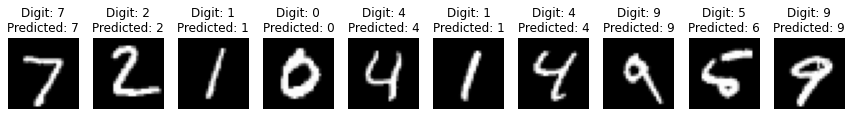

In [116]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN1.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 



for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Notiamo che nella maggior parte dei casi il modello con ottimizzatore SGD è in grado di predirre correttamente i valori delle cifre, tuttavia nel penultimo caso dove c'è un caso di grafia poco precisa il $5$ viene scambiato per un $6$ causando una predizione sbagliata da parte della rete.

Predizione con ottimizzatore **Adagrad**:

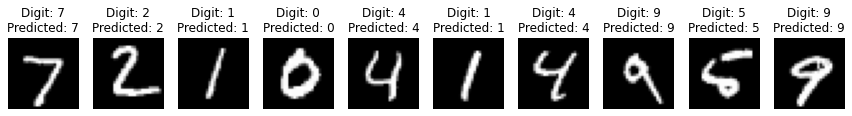

In [111]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN2.predict(X)

X_test = X.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

In questo caso vediamo che il modello con ottimizzatore Adagrad risulta in grado di predirre in modo accurato anche la penultima cifra. 

### Esercizio 12.2

Nel secondo esercizio ci viene chiesto di affrontare il medesimo problema di classificazione utilizzando questa volta una rete neurale di tipo convoluzionale CNN. Le reti neurali convoluzionali sono costruite ad-hoc per il riconoscimento e la classificazione di immagini, si differenziano dalle reti neurali profonde per la presenza di layer specifici. 

Le reti neurali convoluzionali sono formate da:

- **layer di convoluzione** : attuano l'operazione matematica di convoluzione tra l'input, ovvero l'immagine formata da $28\times28$ pixel e dei filtri o kernel, ovvero delle matrici quadrate con dimensioni variabili. I layer sono caratterizzati da tre quantità: altezza, larghezza e numero di canali, per un'immagine a colori i canali sono $3$, mentre per un'immagine in bianco e nero il canale è uno solo. Lo scopo della convoluzione e quindi dell'applicazione dei filtri è quella di far risaltare le principali features che caratterizzano una certa immagine. Fondamentale nei processi di classificazione è infatti la capacità di riconoscere delle caratteristiche uniche che ci permettono di distringuere e riconoscere un'immagine da un'altra. Ad un layer convoluzionale possiamo applicare un numero a piacere di filtri, ogni filtro produrrà come risultato un'immagine con una specifica feature accentuata. In generale i filtri riducono la dimensione dell'immagine di input a meno che non venga introdotto un "contorno" all'immagine iniziale tramite l'operazione di padding.

- **layer di pooling**: questi layer restringono l'immagine proveniente dal layer precedente e ne dimezzano le dimensioni. Nei layer di max-pooling questa operazione viene effettuata dividendo idealmente l'immagine in matrici $2\times2$ contigue e prendendo il massimo valore contenuto in ogni matrice, questi valori andranno a formare una nuova immagine con dimensioni dimezzate rispetto a quelle di partenza, ma che contiene ancora tutta l'informazione necessaria al riconoscimento. 

- **layer densi**: dopo il layer di pooling si trovano generalmente dei layer standar completamente connessi, in questi layer l'immagine in formato matriciale proveniente dal layer precedente viene ridimensionata in un vettore di lunghezza pari al numero di componenti della matrice uscente dal pooling. 

- **layer di output**: il layer di output è formato da dieci neuroni, ognuno corrispondente ai valori compresi tra $0$ e $9$, questo layer è caratterizzato da una funzione di attivazione 'softmax' che ha lo scopo di accendere il neurone che con più probabilità predice il valore della cifra dell'immagine di input.

Prima di procedere con la creazione della rete è necessario fare una reshape dei dati.

In [48]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


Costruiamo ora la nostra rete convoluzionale. Decidiamo di utilizzare la seguente struttura:
- layer convoluzionale `Conv2D` con $10$ filtri $5\times 5$;
- layer di maxpooling `MaxPooling2D` con finestra di pooling $2\times2$;
- layer convoluzionale `Conv2D` con $10$ filtri $5\times 5$;
- layer di maxpooling `MaxPooling2D` con finestra di pooling $2\times2$;
- layer di flatten `Flatten`;
- layer denso `Dense` formato da $100$ neuroni all-to-all con funzione di attivazione 'relu';
- layer di dropout `Dropout` con rate di $0.5$;
- layer denso `Dense` formato da $50$ neuroni all-to-all con funzione di attivazione 'relu';
- layer di output formato da $10$ neuroni con funzione di attivazione `soft-max`.

In [ ]:
#model_CNN.summary()

In [17]:
num_classes=10 #numbers of output neurons

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    #maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    #another convoltuional and maxpooling layer
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    #dense layers
    #first we have to flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))   
    #apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # add a dense all-to-all relu layer
    model.add(Dense(50, activation='relu'))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['accuracy'])
    return model


Utilizziamo come ottimizzatore lo stochastic gradient descent e come funzione di loss la categorical crossentropy. Alleniamo la rete utilizzando un numero di epoche pari a $10$.

In [18]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))


In [19]:
#model_CNN.summary()

Riportiamo di seguito i valori della loss e dell'accuratezza per i dati di test.

In [20]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.061939526317070705
Test accuracy: 0.9794999957084656


Dai dati ottenuti vediamo che il modello raggiunge un'accuratezza elevata.

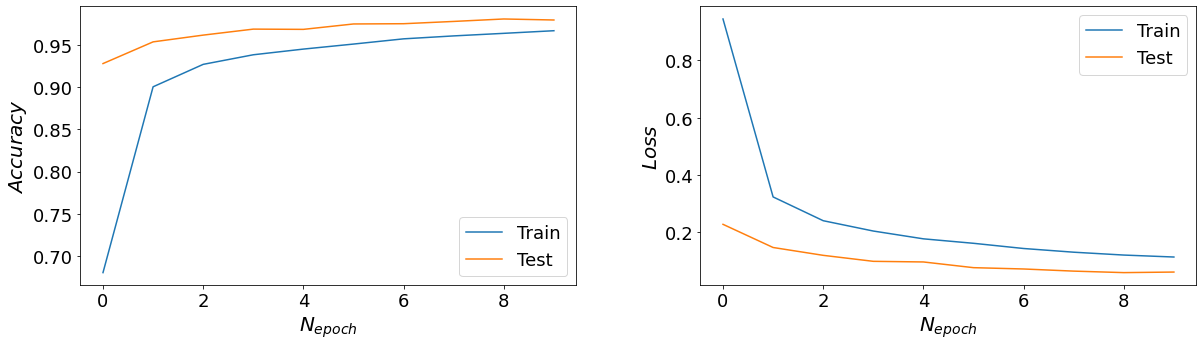

In [31]:
plt.figure(figsize=(20,5))

# look into training history
plt.subplot(1,2,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('$Accuracy$', fontsize=20)
plt.xlabel('$N_{epoch}$', fontsize=20)
plt.legend(['Train', 'Test'], loc='best', fontsize= 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(1,2,2)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('$Loss$', fontsize=20)
plt.xlabel('$N_{epoch}$', fontsize=20)
plt.legend(['Train', 'Test'], loc='best', fontsize= 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplots_adjust(top=0.9, wspace=0.25, hspace=0.3)


plt.show()

Applichiamo ora il modello ai dati di test e analizziamo le predizioni.

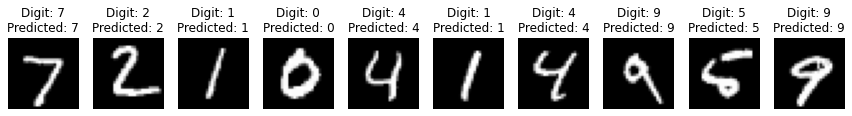

In [26]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Come possiamo vedere la rete è in grado di predirre in modo corretto tutte le cifre introdotte, anche la penultima.

### Esercizio 12.3

In quest ultimo esercizio ci viene richiesto di utilizzare l'applicazione `gimp` per creare $10$ immagini di cifre scritte a mano, importarle nel notebook e vedere se la rete neurale convoluzionale appena creata riesce a predirre le cifre.

In [32]:
from PIL import Image
import os

digit_filename = ["./0.png", "./1.png", "./2.png", "./3.png", "./4.png", "./5.png", "./6.png", "./7.png", 
                  "./8.png", "./9.png"]
digit_in = []

for i in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[i]).convert('L'))
    
ydim, xdim = digit_in[0].size

pix = []
for i in range(len(digit_filename)):
    pix.append(digit_in[i].load());
data = np.zeros((len(digit_filename),xdim, ydim))

for l in range(len(digit_filename)):
    for k in range(ydim):
        for i in range(xdim):
            data[l][i,k]=pix[l][k,i]
            
for i in range(len(digit_filename)):
    data[i] /= 255

Riportiamo di seguito le previsioni della rete.

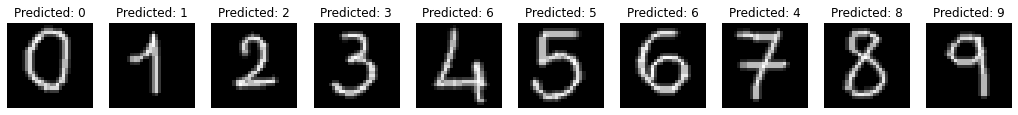

In [45]:
#CNN case
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)
    
#CNN model    
prediction_CNN = model_CNN.predict(data_CNN)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')
    plt.title("Predicted: {}".format(np.argmax(prediction_CNN[i]))) 
    plt.axis('off') 
plt.show()

Come vediamo la rete neurale convoluzionale predice le cifre scritte a mano nel modo giusto l'$80\%$ delle volte, per migliorare le sue performace proviamo ad allenarla per un numero di epoche maggiore, imponiamo $N_{epoch}=20$.

In [ ]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)
#print()
#print(X_train.shape[0], 'train samples')
#print(X_test.shape[0], 'test samples')

In [49]:
# training parameters
batch_size = 32
epochs = 20

# create the deep conv net
model_CNN1=create_CNN()

# train CNN
history = model_CNN1.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [50]:
# evaluate model
score = model_CNN1.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.044066252019262175
Test accuracy: 0.9842000007629395


Vediamo che aumentando il numero di epoche l'accuratezza del modello aumenta.

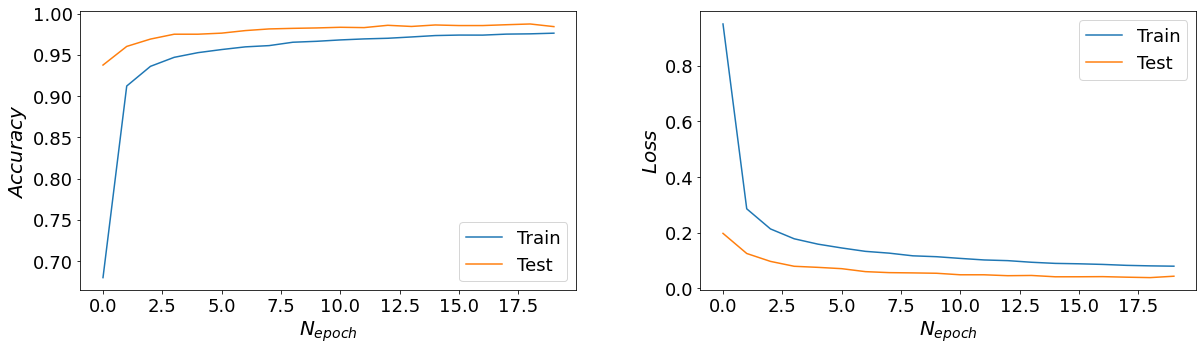

In [51]:
plt.figure(figsize=(20,5))

# look into training history
plt.subplot(1,2,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('$Accuracy$', fontsize=20)
plt.xlabel('$N_{epoch}$', fontsize=20)
plt.legend(['Train', 'Test'], loc='best', fontsize= 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(1,2,2)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('$Loss$', fontsize=20)
plt.xlabel('$N_{epoch}$', fontsize=20)
plt.legend(['Train', 'Test'], loc='best', fontsize= 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplots_adjust(top=0.9, wspace=0.25, hspace=0.3)


plt.show()

Previsione del modello:

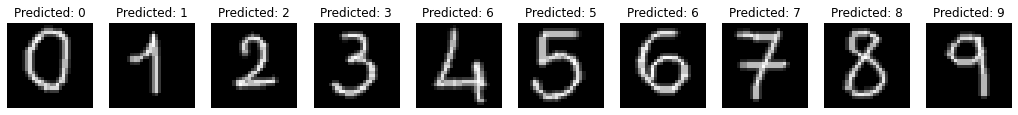

In [52]:
#CNN case
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)
    
#CNN model    
prediction_CNN = model_CNN1.predict(data_CNN)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')
    plt.title("Predicted: {}".format(np.argmax(prediction_CNN[i]))) 
    plt.axis('off') 
plt.show()

Come vediamo dai risultati la rete dopo essere stata allenata un numero maggiore di epoche riesce a predirre in modo corretto il $90\%$ delle cifre.

Applichiamo ora il modello con ottimizzatore Adagrad risultato migliore nel primo esericizio per predirre le cifre scritte a mano così da fare un confronto tra risultati ottenuti da DNN e CNN.

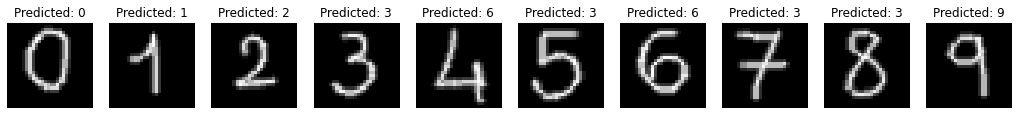

In [46]:
#caso DNN
data_DNN = data.reshape(data.shape[0], xdim*ydim)

#we use Adagrad model
prediction_DNN = model_DNN2.predict(data_DNN)
data_DNN = data_DNN.reshape(data_DNN.shape[0], xdim, ydim, 1)


plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_DNN[i, :, :, 0], cmap='gray')
    plt.title("Predicted: {}".format(np.argmax(prediction_DNN[i]))) 
    plt.axis('off') 
plt.show()

Dai risultati vediamo che solo nel $60\%$ dei casi la rete riesce a predirre in modo corretto le cifre scritte a mano, probabilmente aumentando il numero di epoche si potrebbe ottenere un risultato migliore. In generale possiamo dire che i risultati ottenuti per il riconoscimento e la classificazione delle immagini tramite la rete CNN risultano migliori rispetto alla rete DNN.